In [1]:
# NiN网络: 网络中的网络. 
# 首先导入：包
import torch
from torch import nn
from d2l import torch as d2l


# 首先我们实现一下nin块
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        # 然后跟上两个1*1的卷积层. 不改变输出通道, K=1, p=0, S=1,这样我们不改变输入和输出通道的形状.
        nn.Conv2d(out_channels,  out_channels, kernel_size=1, stride=1, padding=0), nn.ReLU(), 
        nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0), nn.ReLU()


    )

# class my_sequtial():
    


In [2]:
# 构建NiN模型: NiN是基于AlexNet架构的. 
# 就是通道数变化都差不太多的.
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, 2), 
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, 2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, 2),
    nn.Dropout(0.5),
    # 类别墅是10: 最后我们将通道数降为10, 作为我们最后输出的结果
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    
    # 最后使用全局平均池化层:
    nn.AdaptiveAvgPool2d((1, 1)), # 我们只要最终输出的形状即可. 为output_size, 只是将高宽维度输出为1, 1
    # 所以形状为: (batch, 10, 1, 1)

    # 将四维的输出转换成二维
    nn.Flatten()

)
# 这里没有写softmax, 因为
# 随着深度学习框架的发展，为了更好的性能，部分框架选择了在使用交叉熵损失函数时默认加上softmax，
# 这样无论你的输出层是什么，只要用了nn.CrossEntropyLoss就默认加上了softmax。
# 所以很多模型不显示的去写softmax回归了. 

In [3]:
# 查看每层形状变化: 
X = torch.randn(size=(1, 1, 224, 224))
for layer in net:
    X  = layer(X)
    print(f"{layer.__class__.__name__:10.10}\t", X.shape)

Sequential	 torch.Size([1, 96, 54, 54])
MaxPool2d 	 torch.Size([1, 96, 26, 26])
Sequential	 torch.Size([1, 256, 26, 26])
MaxPool2d 	 torch.Size([1, 256, 12, 12])
Sequential	 torch.Size([1, 384, 12, 12])
MaxPool2d 	 torch.Size([1, 384, 5, 5])
Dropout   	 torch.Size([1, 384, 5, 5])
Sequential	 torch.Size([1, 10, 5, 5])
AdaptiveAv	 torch.Size([1, 10, 1, 1])
Flatten   	 torch.Size([1, 10])


loss 0.300, train acc 0.892, test acc 0.891
2867.7 examples/sec on cuda:0


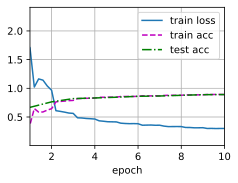

In [4]:
# 训练模型: 
# 定义参数
lr, batch_size, num_epoch = 2e-1, 32, 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epoch, lr, d2l.try_gpu() )

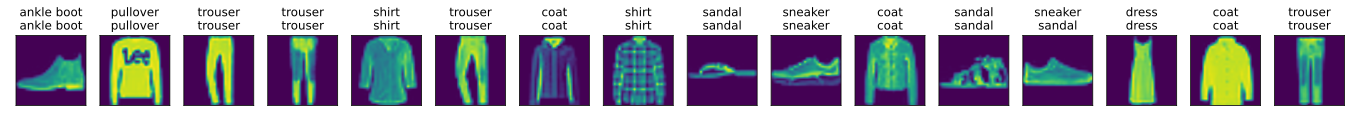

In [14]:
# d2l.predict_ch3()
# predict
    # for X, y in test_iter:
    #     break
    # trues = d2l.get_fashion_mnist_labels(y)
    # preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X), axis=1))
    # titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    # d2l.show_images(
    #     d2l.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])
    
    
def predict_fashin_mnist(net: nn.Module, test_iter: torch.utils.data.DataLoader, n = 16, device=d2l.try_gpu()):
    for X, y in test_iter:
        break
    X = X.to(device)
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).cpu())
    X = X.cpu()
    
    titles = [true + "\n" + pred for true, pred in zip(trues, preds)]
    d2l.show_images(d2l.reshape(X[0: n], (n, 224, 224)), 1, n, titles=titles)

predict_fashin_mnist(net, test_iter)